In [32]:
import json
import configparser
import requests
import time
from datetime import datetime, timedelta
from conj_gen import TLEday, pos_file, pos_tle, conj_tle_ub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class MyError(Exception):
    def __init___(self,args):
        Exception.__init__(self,"my exception was raised with arguments {0}".format(args))
        self.args = args

uriBase                = "https://for-testing-only.space-track.org"
requestLogin           = "/ajaxauth/login"
requestCmdAction       = "/basicspacedata/query" 

config = configparser.ConfigParser()
config.read("./SpTrack.ini")
configUsr = config.get("configuration","username")
configPwd = config.get("configuration","password")
siteCred = {'identity': configUsr, 'password': configPwd}

a = pd.read_pickle('07_12_conj.pkl')
b = a.loc[a['conj-dist'] < 100]

In [35]:
print(b.sort_values(by='conj-dist'))

     sat-ID  int-index           conj-time  conj-dist
749    8197      154.0 2011-11-08 16:42:00  39.192903
771    8591      149.0 2011-10-28 09:21:58  40.134123
393    1208      156.0 2011-11-13 05:14:00  48.101274
790    8845      133.0 2011-08-21 12:58:42  48.579590
271   34808      114.0 2011-07-09 12:19:51  61.665882
89    25039      122.0 2011-07-27 14:24:59  65.421226
1307  18312      163.0 2011-11-29 01:00:09  69.444480
342     340      168.0 2011-12-10 08:23:42  69.529740
1300  18214      119.0 2011-07-20 19:24:12  72.225302
1033  13492      130.0 2011-08-14 17:49:13  80.172261
690    7094      160.0 2011-11-22 06:19:47  81.060076
1099  14819      119.0 2011-07-20 19:27:30  89.088552
360     728      156.0 2011-11-13 05:14:25  92.525665
621    6019      168.0 2011-12-10 08:23:29  94.727894
414    1510      139.0 2011-09-04 02:42:43  99.304632


In [37]:
def findTLE(sat, t1, t2):
    
    requestFindTLE   = "/class/gp_history/NORAD_CAT_ID/" + str(sat) + "/EPOCH/" + str(t1) + "--" + str(t2) + "/format/json/"
    
    with requests.Session() as session:

        resp = session.post(uriBase + requestLogin, data = siteCred)
        if resp.status_code != 200:
            raise MyError(resp, "POST fail on login")

        resp = session.get(uriBase + requestCmdAction + requestFindTLE)
        if resp.status_code != 200:
            print(resp)
            raise MyError(resp, "GET fail on request for satellites")

        retData = json.loads(resp.text)
        
    session.close()
    
    tle = []
    for t in retData:
        tle = np.append(tle, [[t['TLE_LINE1']], [t['TLE_LINE2']]])
    
    return tle

def conj_gen(sat, conj_time, hrs):
    
    # reading TLEs of C2
    c2_tle = open('26464tle.txt','r').readlines()
    
    # obtaining TLEs of satellite day before and day after
    conj_dt = conj_time.to_pydatetime()
    t1 = datetime(conj_dt.year, conj_dt.month, conj_dt.day) + timedelta(days = -1)
    t2 = datetime(conj_dt.year, conj_dt.month, conj_dt.day) + timedelta(days = 1)
#     print(t1, t2)
    tle = findTLE(sat, t1, t2)
#     print(tle)
    
    # calculating positions
    conj_jd = conj_time.to_julian_date()
    jd_start = conj_jd - hrs/48
    jd_end = conj_jd + hrs/48
#     print(jd_start, jd_end)
    
    r1 = pos_tle(tle, jd_start, jd_end)
    r2 = pos_tle(c2_tle, jd_start, jd_end)
    
    return r1, r2

In [41]:
r1, r2 = conj_gen(8197, b.loc[749,'conj-time'], 3)

In [47]:
np.savetxt('8197conj.csv', r1, delimiter=',')
np.savetxt('8197conj_c2.csv', r2, delimiter=',')

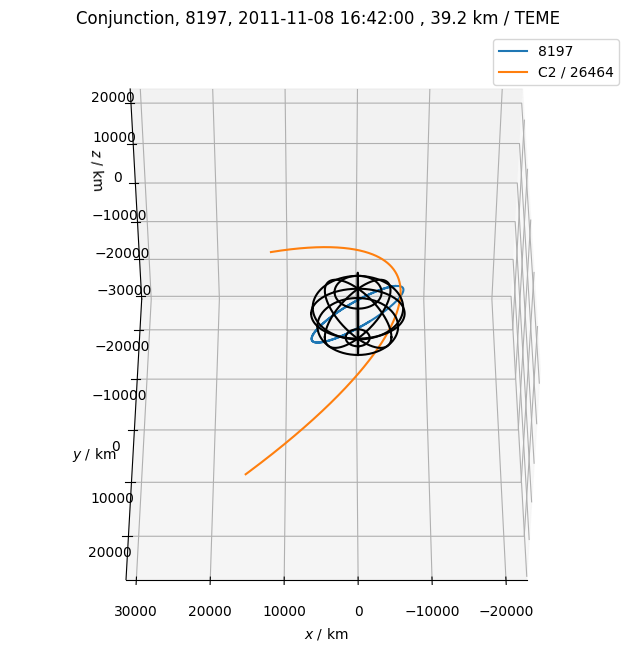

In [46]:
fig = plt.figure(figsize=[10, 8])

ax  = fig.add_subplot(1, 1, 1, projection='3d')

ax.plot(r1[:,0], r1[:,1], r1[:,2],label='8197')
ax.plot(r2[:,0], r2[:,1], r2[:,2],label='C2 / 26464')

for x, y, z in lons:
    ax.plot(x, y, z, '-k')
for x, y, z in lats:
    ax.plot(x, y, z, '-k')

ax.view_init(45, 90)
# ax.view_init(90, 90)
# ax.view_init(0, 270)

ax.legend()
ax.set_xlabel('$x$ / km')
ax.yaxis.set_rotate_label(False)
ax.set_ylabel('$y$ / km')
# ax.zaxis.set_rotate_label(False)
ax.set_zlabel('$z$ / km')
plt.title('Conjunction, 8197, 2011-11-08 16:42:00 , 39.2 km / TEME')

# ax.set_xlim(-20000,20000)

centers, hw = makecubelimits(ax)
plt.savefig('8197_conj_1.png',dpi=300,bbox_inches='tight')
plt.show()

In [30]:
# run this before running the plot

def makecubelimits(axis, centers=None, hw=None):
    lims = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()
    if centers == None:
        centers = [0.5*sum(pair) for pair in lims] 

    if hw == None:
        widths  = [pair[1] - pair[0] for pair in lims]
        hw      = 0.5*max(widths)
        ax.set_xlim(centers[0]-hw, centers[0]+hw)
        ax.set_ylim(centers[1]-hw, centers[1]+hw)
        ax.set_zlim(centers[2]-hw, centers[2]+hw)
#         print("hw was None so set to:", hw)
    else:
        try:
            hwx, hwy, hwz = hw
#             print("ok hw requested: ", hwx, hwy, hwz)

            ax.set_xlim(centers[0]-hwx, centers[0]+hwx)
            ax.set_ylim(centers[1]-hwy, centers[1]+hwy)
            ax.set_zlim(centers[2]-hwz, centers[2]+hwz)
        except:
#             print("nope hw requested: ", hw)
            ax.set_xlim(centers[0]-hw, centers[0]+hw)
            ax.set_ylim(centers[1]-hw, centers[1]+hw)
            ax.set_zlim(centers[2]-hw, centers[2]+hw)

    return centers, hw

r_e = 6371.

theta = np.linspace(0, 2*np.pi, 201)
cth, sth, zth = [f(theta) for f in (np.cos, np.sin, np.zeros_like)]
lon0 = r_e*np.vstack((cth, zth, sth))
lons = []
for phi in np.pi/180*np.arange(0, 180, 45):
    cph, sph = [f(phi) for f in (np.cos, np.sin)]
    lon = np.vstack((lon0[0]*cph - lon0[1]*sph,
                     lon0[1]*cph + lon0[0]*sph,
                     lon0[2]) )
    lons.append(lon)

lat0 = r_e*np.vstack((cth, sth, zth))
lats = []
for phi in np.pi/180*np.arange(-75, 90, 45):
    cph, sph = [f(phi) for f in (np.cos, np.sin)]
    lat = r_e*np.vstack((cth*cph, sth*cph, zth+sph))
    lats.append(lat)